In [2]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [3]:
df = pd.read_csv('../datasets/predict_future_sales/sales_train.csv')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Exercise 2: Basic EDA

### Checking for missing value

In [4]:
df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

There seems to be no missing values in the test_data, so it's better to check the distribution of the column to locate possibly hidden nans.

**"date" column**

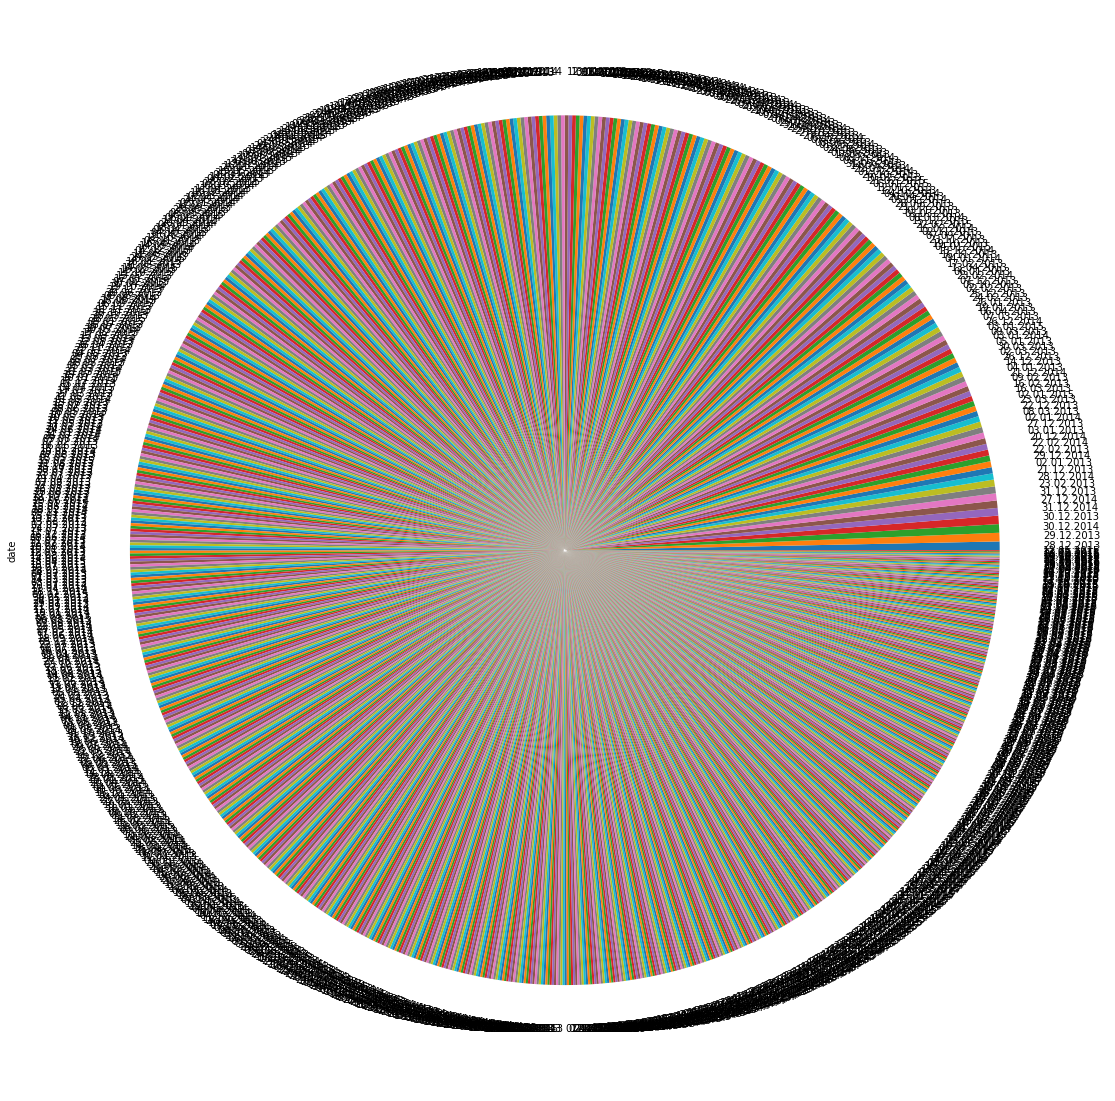

In [5]:
plt.figure(figsize=(20,20))
df.date.value_counts().plot.pie()

**Numerical Value Distributions**

Text(0.5, 1.0, 'item_cnt_day')

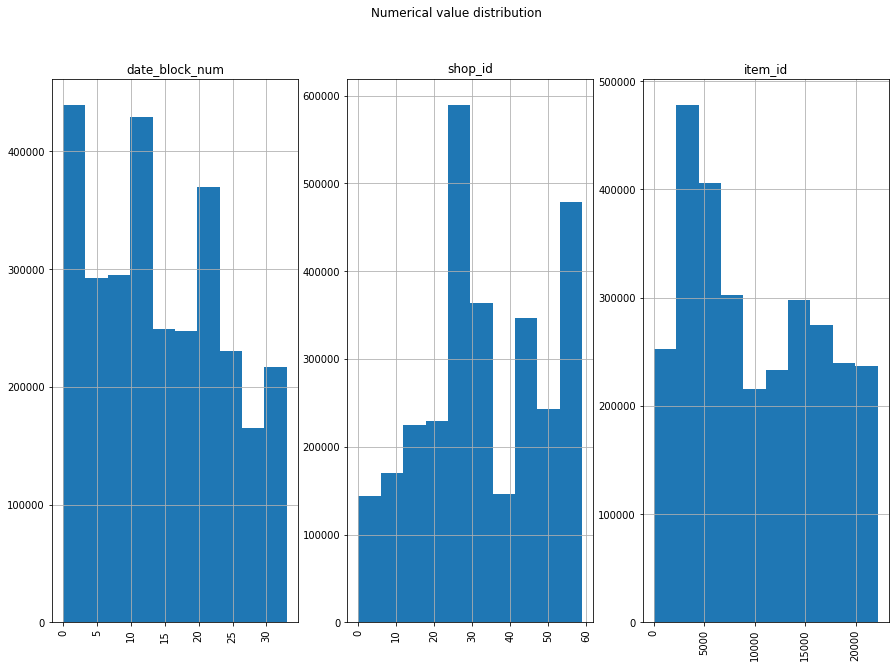

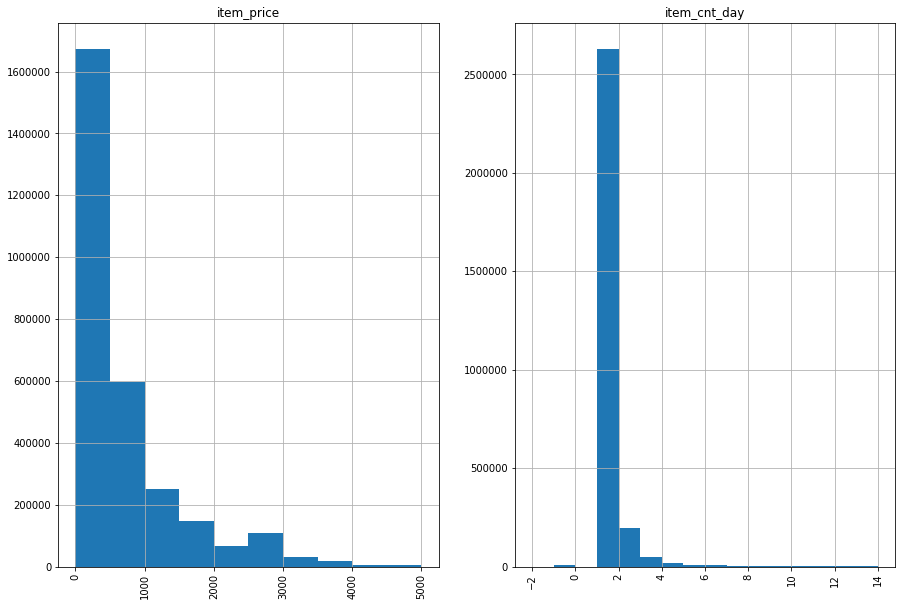

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,10))
df.date_block_num.hist(ax=axes[0], xrot=90)
df.shop_id.hist(ax=axes[1], xrot=90)
df.item_id.hist(ax=axes[2], xrot=90)
axes[0].set_title('date_block_num')
axes[1].set_title('shop_id')
axes[2].set_title('item_id')
fig.suptitle('Numerical value distribution')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
df.item_price.hist(bins=[0, 500, 1000, 1500, 2000, 2500,3000, 3500, 4000, 4500, 5000],
                   ax=axes[0], xrot=90)
df.item_cnt_day.hist(bins= np.arange(-2, 15), ax=axes[1], xrot=90)
axes[0].set_title('item_price')
axes[1].set_title('item_cnt_day')

It seems there aren't any strange values that can indicate nans. <br>
Anyway, we have some negative values in "item_cnt_day", they probably stand for items that have been returned, but it's useful to keep that in mind

### Checking for outliers

Text(0.5, 1.0, 'item_cnt_day')

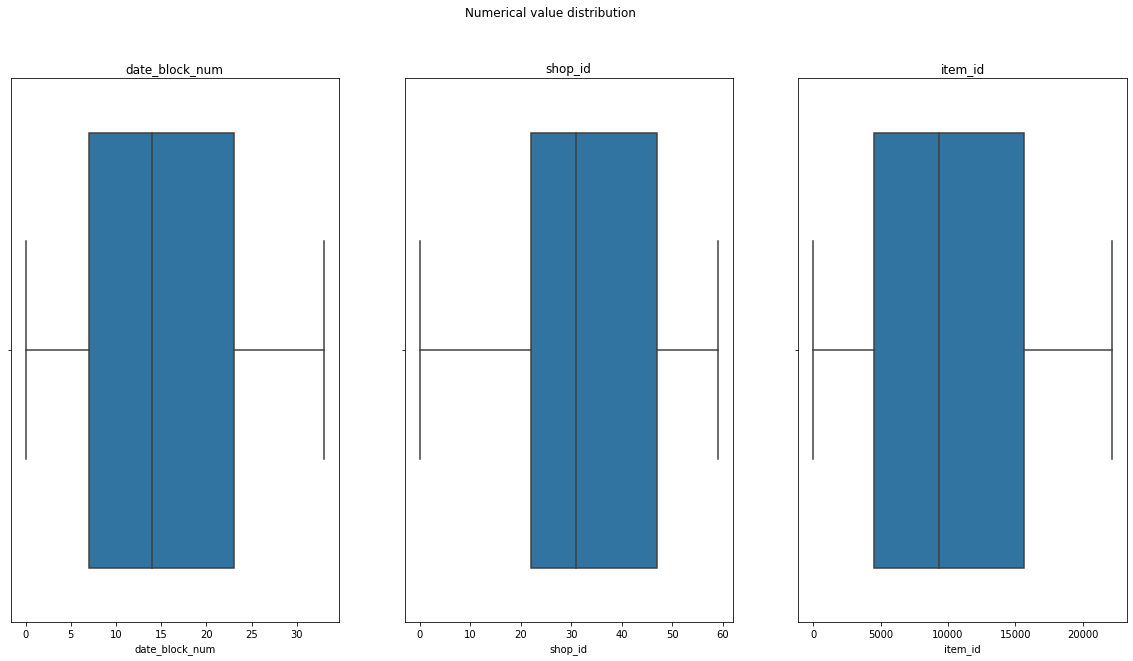

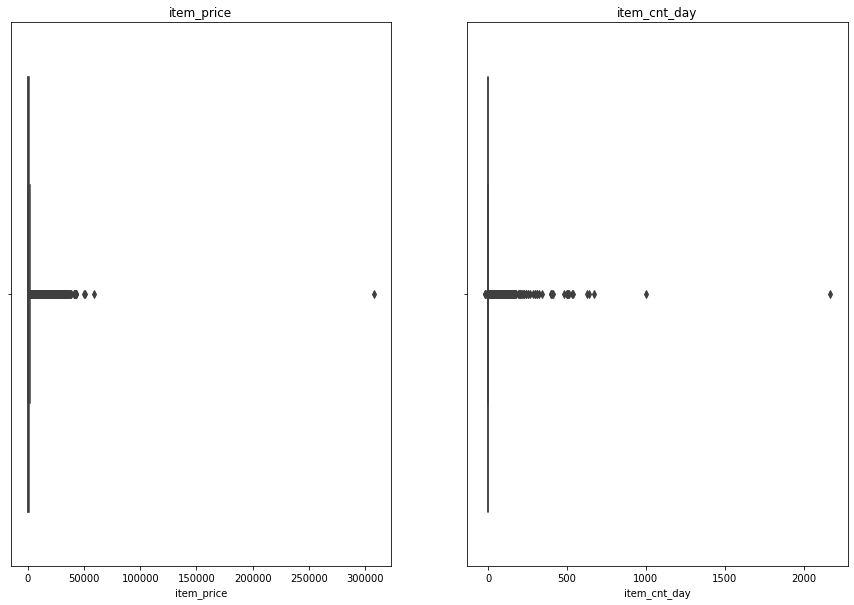

In [7]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,10))
sns.boxplot(df.date_block_num, ax=axes[0])
sns.boxplot(df.shop_id,ax=axes[1])
sns.boxplot(df.item_id, ax=axes[2])
axes[0].set_title('date_block_num')
axes[1].set_title('shop_id')
axes[2].set_title('item_id')
fig.suptitle('Numerical value distribution')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.boxplot(df.item_price, ax=axes[0])
sns.boxplot(df.item_cnt_day, ax=axes[1])
axes[0].set_title('item_price')
axes[1].set_title('item_cnt_day')

From the boxplots we see that "item_price" and "item_cnt_day" have a lot of outliers, with some data points really far away. We can do some further investigation on those columns

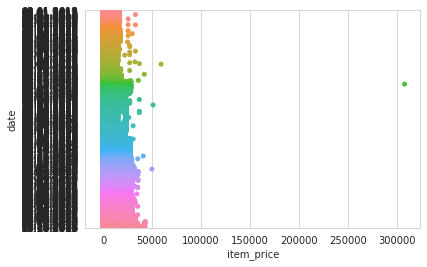

In [23]:
#sns.set_style(style="whitegrid")
#ax = sns.stripplot(x=df.item_price, y=df.date, data=df)

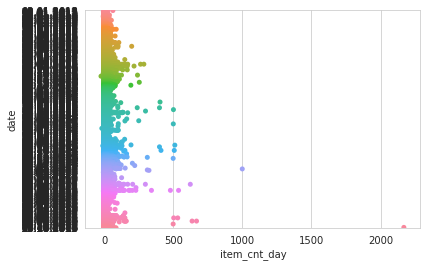

In [24]:
#sns.set_style(style="whitegrid")
#ax = sns.stripplot(x=df.item_cnt_day, y=df.date, data=df)

In [8]:
max_price = df.item_price.max()
df.loc[df.item_price == max_price]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [9]:
df.loc[df.item_cnt_day > 800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


For now, let's just drop them.

In [21]:
df_dropped = df.drop(df.loc[df.item_price == max_price].index)
df_dropped = df_dropped.drop(df.loc[df.item_cnt_day > 800].index)
print(df.shape)
print(df_dropped.shape)

(2935849, 6)
(2935846, 6)


# Exercise 3

**1. Filter to obtain only the sales from Octuber 2015 (date_block_num==33)**

In [29]:
df_october = df.loc[df.date_block_num == 33]
df_october.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0


**2. Do some aggregation to convert from day detail to month detail (groupby)**

In [39]:
df_grouped = df_october.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
df_grouped

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


**3. Filter the aggregated shop-item pairs to get only the pairs needed at test (merge)**

In [52]:
test = pd.read_csv('../datasets/predict_future_sales/test.csv', index_col='ID')
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [53]:
df_merged = test.merge(df_grouped, how='left', on=['shop_id', 'item_id'])
df_merged

,shop_id,item_id,item_cnt_day
0,5,5037,NaN
1,5,5320,NaN
2,5,5233,1.0
3,5,5232,NaN
4,5,5268,NaN
...,...,...,...
214195,45,18454,1.0
214196,45,16188,NaN
214197,45,15757,NaN
214198,45,19648,NaN


**4. Fill NaNs with zeros (.fillna(0))**

In [56]:
df_merged.fillna(0, inplace=True)
df_merged

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0
...,...,...,...
214195,45,18454,1.0
214196,45,16188,0.0
214197,45,15757,0.0
214198,45,19648,0.0


**5.Limit your predictions to the range [0,...,20] (.clip(lower=0, upper=20))**

In [57]:
df_merged.item_cnt_day = df_merged.item_cnt_day.clip(lower=0, upper=20)
df_merged

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0
...,...,...,...
214195,45,18454,1.0
214196,45,16188,0.0
214197,45,15757,0.0
214198,45,19648,0.0


In [69]:
# creating dataframe for submission
sub = df_merged[['item_cnt_day']]
sub.index.name = 'ID'
sub.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
sub

/home/lpianta/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
214195,1.0
214196,0.0
214197,0.0


In [70]:
# exporting
sub.to_csv('oct2015.csv')